In [1]:
from mpasanalysis import *
import e3sm_res_cmp
%matplotlib inline

In [2]:
# get paths of restart files, monthly mean output files, processed climatology files and output figures
data_root = e3sm_res_cmp.load_paths_ocn(climo_ys=41, climo_ye=50, ts_ys=1, ts_ye=50)
rst_root = data_root['rst_root']
climo_root = data_root['climo_root']
mon_root = data_root['mon_root']
fig_root = data_root['fig_root']
rst_file = rst_root+'/mpaso.rst.0051-01-01_00000.nc'
mon_file = mon_root+'/mpaso.hist.am.timeSeriesStatsMonthly.0041-01-01.nc'

Running on machine pn1803144.lanl.gov


In [3]:
# load dataset
mpasmesh = MPASMesh(filepath=rst_file)
mpasdata = MPASOData(filepath=mon_file, filepath_mesh=rst_file)
varname_prefix='timeMonthly_avg_'

### Test 1: Get path between two end points 

#### Step 1: Show the path 

Endpoints:
    P0: 304.5 53.5
    P1: 312.0 61.0
    P2: 320.0 50.0
Vertex closest to P0: 304.58613 53.44701
Vertex closest to P1: 312.08908 60.99671
Vertex closest to P0: 312.08908 60.99671
Vertex closest to P1: 319.99442 49.93214
Vertex closest to P0: 319.99442 49.93214
Vertex closest to P1: 304.58613 53.44701
Reading mesh data from /Users/qingli/data/mpas/test/mpaso.rst.0051-01-01_00000.nc
Plotting map of Bottom Depth (m) at region 'LabSea'


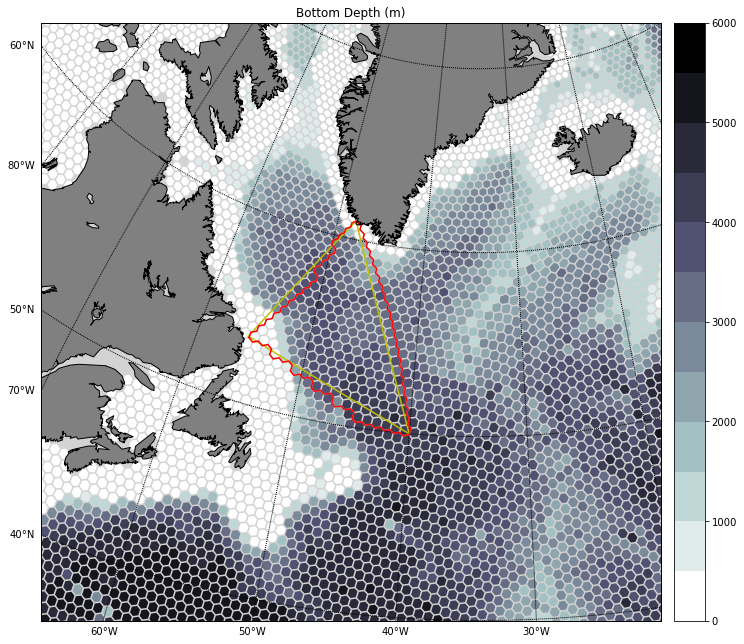

In [4]:
# set endpoints
lon_p0, lat_p0 = 304.5, 53.5
lon_p1, lat_p1 = 312, 61
lon_p2, lat_p2 = 320, 50
print('Endpoints:')
print('    P0: {:4.1f} {:4.1f}'.format(lon_p0, lat_p0))
print('    P1: {:4.1f} {:4.1f}'.format(lon_p1, lat_p1))
print('    P2: {:4.1f} {:4.1f}'.format(lon_p2, lat_p2))
# get the shortest path
path0 = mpasmesh.get_shortest_path(lon_p0, lat_p0, lon_p1, lat_p1, debug_info=False) 
path1 = mpasmesh.get_shortest_path(lon_p1, lat_p1, lon_p2, lat_p2, debug_info=False)
path2 = mpasmesh.get_shortest_path(lon_p2, lat_p2, lon_p0, lat_p0, debug_info=False) 

fig = plt.figure(figsize=[12,11])
levels = np.linspace(0, 6000, 13)
out = mpasmesh.get_map('bottomDepth', name='Bottom Depth'). \
      plot(region='LabSea', ptype='pcolor', cmap='bone_r', levels=levels)
m = out[0]
# plot cross sections
m.drawgreatcircle(lon_p0, lat_p0, lon_p1, lat_p1, color='y')
m.drawgreatcircle(lon_p1, lat_p1, lon_p2, lat_p2, color='y')
m.drawgreatcircle(lon_p2, lat_p2, lon_p0, lat_p0, color='y')
# plot all edges
mpasmesh.plot_edges(m, colors='lightgray')
# plot paths
path0.plot_edge(m, c='r')
path1.plot_edge(m, c='r')
path2.plot_edge(m, c='r')

#### Step 2: Compute the volume transport 

In [5]:
transport0 = mpasdata.get_transport(path=path0, varname_prefix='timeMonthly_avg_')
print('Transport across path P0-P1: {:6.4e} m^3/s'.format(transport0[0]))
transport1 = mpasdata.get_transport(path=path1, varname_prefix='timeMonthly_avg_')
print('Transport across path P1-P2: {:6.4e} m^3/s'.format(transport1[0]))
transport2 = mpasdata.get_transport(path=path2, varname_prefix='timeMonthly_avg_')
print('Transport across path P2-P0: {:6.4e} m^3/s'.format(transport2[0]))
print('Net transport (excluding surface flux): {:6.4e} m^3/s'.format(transport0[0]+transport1[0]+transport2[0]))

Transport across path P0-P1: 1.8005e+05 m^3/s
Transport across path P1-P2: 1.0913e+07 m^3/s
Transport across path P2-P0: -1.1412e+07 m^3/s
Net transport (excluding surface flux): -3.1919e+05 m^3/s


### Test 2:  Get the path that encloses a single cell 

#### Step 1: Show the path 

Cell closest to P0: 311.95703 55.16029
Reading mesh data from /Users/qingli/data/mpas/test/mpaso.rst.0051-01-01_00000.nc
Plotting map of Bottom Depth (m) at region 'LabSea'


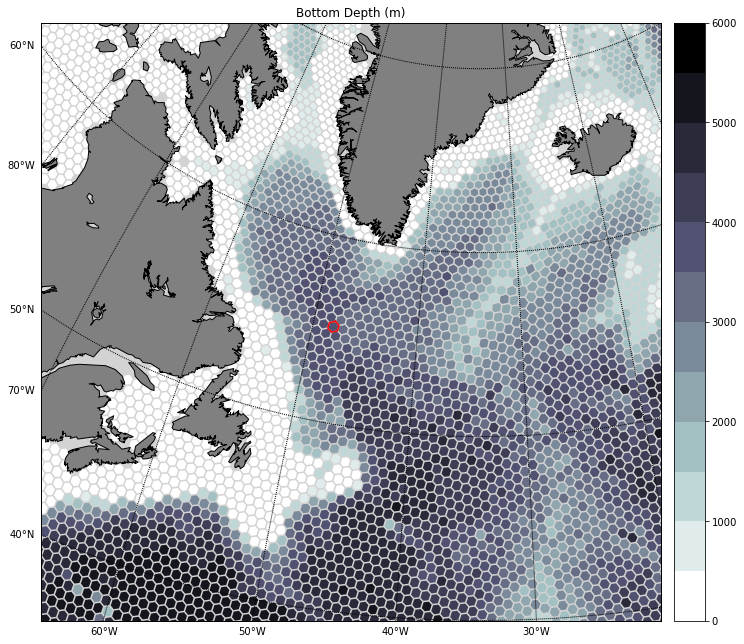

In [6]:
lon_p0, lat_p0 = 312, 55
fmesh = mpasmesh.load()
lon_cell = np.degrees(fmesh.variables['lonCell'][:])
lat_cell = np.degrees(fmesh.variables['latCell'][:])
idx_cell = get_index_latlon(lon_p0, lat_p0, lon_cell, lat_cell)
print('Cell closest to P0: {:8.5f} {:8.5f}'.format(lon_cell[idx_cell], lat_cell[idx_cell]))
path_c = mpasmesh.get_closed_path_cell(idx_cell)

fig = plt.figure(figsize=[12,11])
levels = np.linspace(0, 6000, 13)
out = mpasmesh.get_map('bottomDepth', name='Bottom Depth'). \
      plot(region='LabSea', ptype='pcolor', cmap='bone_r', levels=levels)
m = out[0]
# plot all edges
mpasmesh.plot_edges(m, colors='lightgray')
# plot paths
path_c.plot_edge(m, c='r')

#### Step 2: transport 

In [7]:
transport_c = mpasdata.get_transport(path=path_c, varname_prefix='timeMonthly_avg_')
print('Cell \'{}\''.format(idx_cell+1))
print('  Transport across all edges: {:6.4e} m^3/s'.format(transport_c[0]))
w_surface_c = mpasdata.load().variables['timeMonthly_avg_vertVelocityTop'][0,idx_cell,0]
cellarea_c = mpasmesh.load().variables['areaCell'][idx_cell]
surface_flux_c = w_surface_c*cellarea_c
print('  Surface flux: {:6.4e} m^3/s'.format(surface_flux_c))
print('  Net transport (including surface flux): {:6.4e} m^3/s'.format(transport_c[0]-surface_flux_c))

Cell '99034'
  Transport across all edges: 3.0271e+02 m^3/s
  Surface flux: 3.0313e+02 m^3/s
  Net transport (including surface flux): -4.1995e-01 m^3/s
